# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [9]:
# import libraries
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import isnan, when, count, col, countDistinct, to_timestamp
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [10]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [11]:
df = spark.read.json('mini_sparkify_event_data.json')

In [12]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [13]:
print((df.count(), len(df.columns)))

(286500, 18)


In [14]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [15]:
df.select(col('location')).groupBy('location').count().count()

115

In [16]:
for column in df.columns:
    if df.select(col(column)).groupBy(column).count().count()<30:
        print('\033[1m' + column + '\033[0m') , print(df.select(col(column)).groupBy(column).count().show(30, False))

auth
+----------+------+
|auth      |count |
+----------+------+
|Logged Out|8249  |
|Cancelled |52    |
|Guest     |97    |
|Logged In |278102|
+----------+------+

None
gender
+------+------+
|gender|count |
+------+------+
|F     |154578|
|null  |8346  |
|M     |123576|
+------+------+

None
level
+-----+------+
|level|count |
+-----+------+
|free |58338 |
|paid |228162|
+-----+------+

None
method
+------+------+
|method|count |
+------+------+
|PUT   |261064|
|GET   |25436 |
+------+------+

None
page
+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |14457 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |924   |
|Submit Registration      |5     

In [17]:
df.where(col("firstName").isNull()).select(col('auth')).groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [18]:
df.where(col("firstName").isNull()).select(col('level')).groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free| 2617|
| paid| 5729|
+-----+-----+



In [19]:
df.where(col("firstName").isNull()).select(col('page')).groupBy('page').count().show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|Submit Registration|    5|
|              Login| 3241|
|           Register|   18|
|               Help|  272|
|              Error|    6|
+-------------------+-----+



In [20]:
df.where(col("artist").isNotNull()).select(col('page')).groupBy('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



In [21]:
df.where(col("artist").isNull()).select(col('page')).groupBy('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit Downgrade|   63|
|         Thumbs Down| 2546|
|                Home|14457|
|           Downgrade| 2055|
|         Roll Advert| 3933|
|              Logout| 3226|
|       Save Settings|  310|
|Cancellation Conf...|   52|
|               About|  924|
| Submit Registration|    5|
|            Settings| 1514|
|               Login| 3241|
|            Register|   18|
|     Add to Playlist| 6526|
|          Add Friend| 4277|
|           Thumbs Up|12551|
|                Help| 1726|
|             Upgrade|  499|
|               Error|  258|
+--------------------+-----+
only showing top 20 rows



We have 2 different types of missing values. 

1. Missing user data for 8346 entries. From the analysis above it seems that the users that have null data are users that have not logged in the app yet. As these events cannot be correlated with the userId, we cannot use them, so we will drop them
2. Mssing song data for 58392 entries. From the analysis above it seems that the missing songs are reasonable. The song data are populated only in case the page is the NextSong page, so we will keep all these entries for now

In [22]:
df = df.na.drop(subset=["firstName"])

In [23]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [24]:
df.createOrReplaceTempView("DATA")

In [25]:
spark.sql("""
SELECT count(distinct userId) FROM DATA 
""").show(10, False)

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|225                   |
+----------------------+



In [26]:
spark.sql("""
SELECT distinct userId,page 
FROM DATA 
where page in ('Cancellation Confirmation','Downgrade') 
order by userId,page
""").show(10, False)

+------+-------------------------+
|userId|page                     |
+------+-------------------------+
|10    |Downgrade                |
|100   |Downgrade                |
|100001|Cancellation Confirmation|
|100002|Downgrade                |
|100003|Cancellation Confirmation|
|100004|Downgrade                |
|100005|Cancellation Confirmation|
|100006|Cancellation Confirmation|
|100007|Cancellation Confirmation|
|100007|Downgrade                |
+------+-------------------------+
only showing top 10 rows



In [27]:
spark.sql("""
SELECT page,to_timestamp(ts/1000) as ts,level
FROM DATA 
where userId='100001'
order by ts
""").show(500, False)

+-------------------------+-------------------+-----+
|page                     |ts                 |level|
+-------------------------+-------------------+-----+
|Home                     |2018-10-01 06:48:24|free |
|NextSong                 |2018-10-01 06:48:29|free |
|Roll Advert              |2018-10-01 06:49:02|free |
|NextSong                 |2018-10-01 06:52:27|free |
|Roll Advert              |2018-10-01 06:53:03|free |
|NextSong                 |2018-10-01 07:02:29|free |
|NextSong                 |2018-10-01 07:09:08|free |
|NextSong                 |2018-10-01 07:12:12|free |
|NextSong                 |2018-10-01 07:17:25|free |
|NextSong                 |2018-10-01 07:21:23|free |
|NextSong                 |2018-10-01 07:24:47|free |
|NextSong                 |2018-10-01 07:27:57|free |
|NextSong                 |2018-10-01 07:30:41|free |
|NextSong                 |2018-10-01 07:33:27|free |
|Roll Advert              |2018-10-01 07:33:50|free |
|NextSong                 |2

In [28]:
spark.sql("""
SELECT page,to_timestamp(ts/1000) as ts,level
FROM DATA 
where userId='100002'
order by ts
""").show(500, False)

+---------------+-------------------+-----+
|page           |ts                 |level|
+---------------+-------------------+-----+
|Home           |2018-10-08 22:57:25|paid |
|NextSong       |2018-10-08 22:57:34|paid |
|NextSong       |2018-10-08 23:00:57|paid |
|NextSong       |2018-10-08 23:04:58|paid |
|Add to Playlist|2018-10-08 23:05:07|paid |
|NextSong       |2018-11-06 15:29:54|paid |
|NextSong       |2018-11-06 15:34:18|paid |
|NextSong       |2018-11-06 15:37:56|paid |
|NextSong       |2018-11-06 15:42:00|paid |
|Downgrade      |2018-11-06 15:42:01|paid |
|Downgrade      |2018-11-06 15:42:01|paid |
|NextSong       |2018-11-06 15:46:13|paid |
|NextSong       |2018-11-06 15:57:08|paid |
|NextSong       |2018-11-06 16:03:09|paid |
|NextSong       |2018-11-06 16:06:30|paid |
|NextSong       |2018-11-06 16:11:19|paid |
|NextSong       |2018-11-06 16:14:03|paid |
|NextSong       |2018-11-06 16:16:42|paid |
|NextSong       |2018-11-06 16:21:40|paid |
|NextSong       |2018-11-06 16:2

We can see that even that the user went to Downgrade page he remained paid. I assume that he should do a Submit Downgrade page to consider his downgrade valid

In [29]:
spark.sql("""
SELECT distinct userId,page 
FROM DATA 
where page in ('Cancellation Confirmation','Submit Downgrade') 
order by userId,page
""").show(10, False)

+------+-------------------------+
|userId|page                     |
+------+-------------------------+
|100   |Submit Downgrade         |
|100001|Cancellation Confirmation|
|100003|Cancellation Confirmation|
|100004|Submit Downgrade         |
|100005|Cancellation Confirmation|
|100006|Cancellation Confirmation|
|100007|Cancellation Confirmation|
|100008|Submit Downgrade         |
|100009|Cancellation Confirmation|
|100009|Submit Downgrade         |
+------+-------------------------+
only showing top 10 rows



In [30]:
spark.sql("""
SELECT page,to_timestamp(ts/1000) as ts,level
FROM DATA 
where userId='100009'
order by ts
""").show(500, False)

+----------------+-------------------+-----+
|page            |ts                 |level|
+----------------+-------------------+-----+
|NextSong        |2018-10-01 06:12:51|free |
|NextSong        |2018-10-01 06:16:03|free |
|Thumbs Up       |2018-10-01 06:16:04|free |
|NextSong        |2018-10-01 06:20:02|free |
|NextSong        |2018-10-01 06:23:33|free |
|NextSong        |2018-10-01 06:27:30|free |
|NextSong        |2018-10-01 06:33:44|free |
|NextSong        |2018-10-01 06:38:16|free |
|NextSong        |2018-10-01 06:44:12|free |
|NextSong        |2018-10-01 06:47:28|free |
|Roll Advert     |2018-10-01 06:47:54|free |
|Roll Advert     |2018-10-01 06:47:54|free |
|NextSong        |2018-10-01 06:51:45|free |
|Roll Advert     |2018-10-01 06:52:39|free |
|NextSong        |2018-10-01 06:55:30|free |
|NextSong        |2018-10-01 06:59:52|free |
|NextSong        |2018-10-01 07:03:22|free |
|NextSong        |2018-10-01 07:06:36|free |
|NextSong        |2018-10-01 07:10:19|free |
|NextSong 

This user after the submit upgrade become paid and after the submit downgrade become free again

In [31]:
spark.sql("""
SELECT distinct userId,page 
FROM DATA 
where page in ('Cancellation Confirmation','Submit Downgrade') 
order by userId,page
""").count()

101

In [32]:
df = df.withColumn("churn", when((col("page")=='Cancellation Confirmation') \
                                 | (col("page")=='Submit Downgrade'),1).otherwise(0))

In [33]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

In [34]:
df.createOrReplaceTempView("DATA")

In [35]:
spark.sql("""
SELECT distinct userId,page,churn
FROM DATA 
where page in ('Cancellation Confirmation','Submit Downgrade') 
order by userId,page
""").show(5, False)

+------+-------------------------+-----+
|userId|page                     |churn|
+------+-------------------------+-----+
|100   |Submit Downgrade         |1    |
|100001|Cancellation Confirmation|1    |
|100003|Cancellation Confirmation|1    |
|100004|Submit Downgrade         |1    |
|100005|Cancellation Confirmation|1    |
+------+-------------------------+-----+
only showing top 5 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [36]:
spark.sql("""
SELECT max(to_timestamp(ts/1000)) as max_ts,min(to_timestamp(ts/1000)) as min_ts
FROM DATA 
""").show(5, False)

+-------------------+-------------------+
|max_ts             |min_ts             |
+-------------------+-------------------+
|2018-12-03 01:11:16|2018-10-01 00:01:57|
+-------------------+-------------------+



In [37]:
df_dataset = spark.sql("""
SELECT   DATA.userId,
         case when gender='M' then 1 else 0 end as is_male_flag,
         max(churn) as churn,
         count(distinct ts_day) as days_in_app,
         count(distinct song)/sum(case when song is not null then 1 else 0 end) as avg_songs,
         count(distinct artist)/sum(case when song is not null then 1 else 0 end) as avg_artists,
         round(sum(length/60)/sum(case when song is not null then 1 else 0 end),2) as avg_song_length,
         count(1) as events_cnt, 
         count(1)/count(distinct ts_day) as avg_sessions_per_day,
         sum(case when DATA.page='NextSong' then 1 else 0 end)/count(distinct ts_day) as avg_pg_song_cnt,
         sum(case when DATA.page='Roll Advert' then 1 else 0 end)/count(distinct ts_day) as avg_pg_advert_cnt,
         sum(case when DATA.page='Logout' then 1 else 0 end)/count(distinct ts_day) as avg_pg_logout_cnt,
         sum(case when DATA.page='Thumbs Down' then 1 else 0 end)/count(distinct ts_day) as avg_pg_down_cnt,
         sum(case when DATA.page='Thumbs Up' then 1 else 0 end)/count(distinct ts_day) as avg_pg_up_cnt,
         sum(case when DATA.page='Add Friend' then 1 else 0 end)/count(distinct ts_day) as avg_pg_friend_cnt,
         sum(case when DATA.page='Add to Playlist' then 1 else 0 end)/count(distinct ts_day) as avg_pg_playlist_cnt,
         sum(case when DATA.page='Help' then 1 else 0 end)/count(distinct ts_day) as avg_pg_help_cnt,
         sum(case when DATA.page='Home' then 1 else 0 end)/count(distinct ts_day) as avg_pg_home_cnt,
         sum(case when DATA.page='Save Settings' then 1 else 0 end)/count(distinct ts_day) as avg_pg_save_settings_cnt,
         sum(case when DATA.page='About' then 1 else 0 end)/count(distinct ts_day) as avg_pg_about_cnt,
         sum(case when DATA.page='Settings' then 1 else 0 end)/count(distinct ts_day) as avg_pg_settings_cnt,
         sum(case when DATA.page='Login' then 1 else 0 end)/count(distinct ts_day) as avg_pg_login_cnt,
         sum(case when DATA.page='Submit Registration' then 1 else 0 end)/count(distinct ts_day) as avg_pg_sub_reg_cnt,
         sum(case when DATA.page='Register' then 1 else 0 end)/count(distinct ts_day) as avg_pg_reg_cnt,
         sum(case when DATA.page='Upgrade' then 1 else 0 end)/count(distinct ts_day) as avg_pg_upg_cnt,
         sum(case when DATA.page='Submit Upgrade' then 1 else 0 end)/count(distinct ts_day) as avg_pg_sub_upg_cnt,
         sum(case when DATA.page='Error' then 1 else 0 end)/count(distinct ts_day) as avg_pg_error_cnt
         FROM DATA
         LEFT JOIN 
         (
             SELECT distinct DATE_TRUNC('day', to_timestamp(ts/1000)) as ts_day, userId FROM DATA 
         ) day_ts
         ON day_ts.userId=DATA.userId
         GROUP BY DATA.userId,gender
""")

(array([0, 1]), <a list of 2 Text xticklabel objects>)

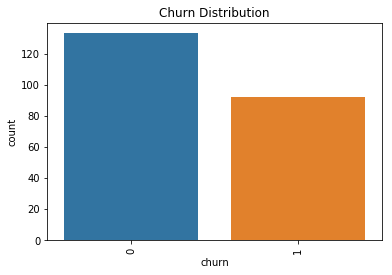

In [38]:
churn_cnt = df_dataset.select(col('churn'),col('userId')).groupby('churn').count().toPandas()
#churn_cnt.show()
sns.barplot('churn','count', data=churn_cnt)
plt.title('Churn Distribution')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

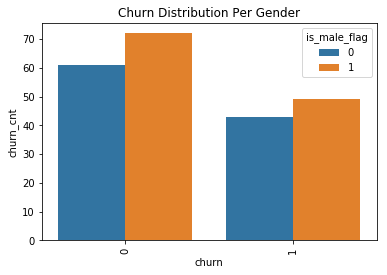

In [39]:
is_male_flag_dstr = df_dataset.select(col('is_male_flag'),col('churn')).groupby('is_male_flag','churn').agg(count("churn").alias("churn_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'churn_cnt', hue = 'is_male_flag', data=is_male_flag_dstr)
plt.title('Churn Distribution Per Gender')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

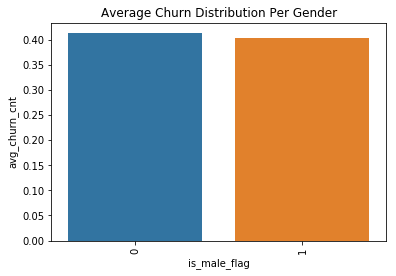

In [40]:
is_male_flag_dstr = df_dataset.select(col('is_male_flag'),col('churn')).groupby('is_male_flag').agg(F.mean("churn").alias("avg_churn_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('is_male_flag', 'avg_churn_cnt', data=is_male_flag_dstr)
plt.title('Average Churn Distribution Per Gender')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

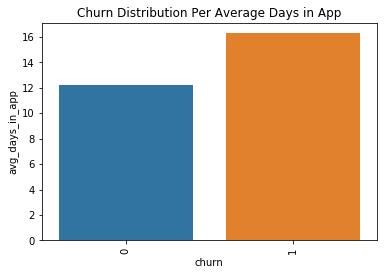

In [41]:
days_in_app_dstr = df_dataset.select(col('days_in_app'),col('churn')).groupby('churn').agg(F.mean("days_in_app").alias("avg_days_in_app")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_days_in_app', data=days_in_app_dstr)
plt.title('Churn Distribution Per Average Days in App')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

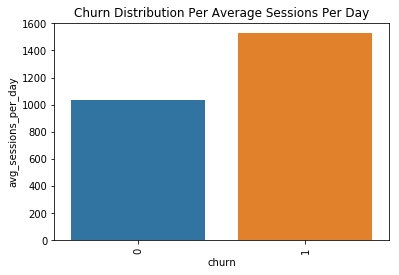

In [42]:
days_in_app_dstr = df_dataset.select(col('avg_sessions_per_day'),col('churn')).groupby('churn').agg(F.mean("avg_sessions_per_day").alias("avg_sessions_per_day")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_sessions_per_day', data=days_in_app_dstr)
plt.title('Churn Distribution Per Average Sessions Per Day')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

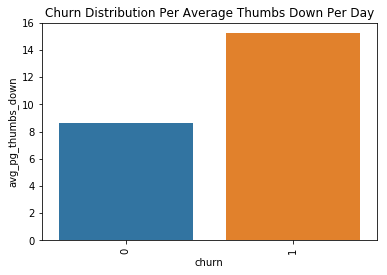

In [43]:
days_in_app_dstr = df_dataset.select(col('avg_pg_down_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_down_cnt").alias("avg_pg_thumbs_down")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_thumbs_down', data=days_in_app_dstr)
plt.title('Churn Distribution Per Average Thumbs Down Per Day')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

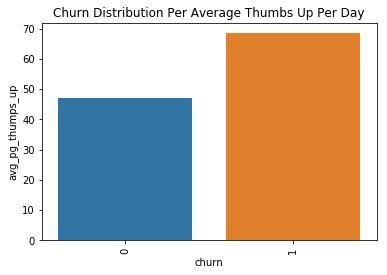

In [44]:
days_in_app_dstr = df_dataset.select(col('avg_pg_up_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_up_cnt").alias("avg_pg_thumps_up")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_thumps_up', data=days_in_app_dstr)
plt.title('Churn Distribution Per Average Thumbs Up Per Day')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

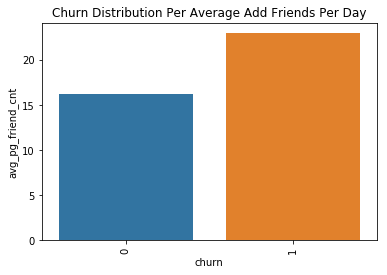

In [45]:
days_in_app_dstr = df_dataset.select(col('avg_pg_friend_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_friend_cnt").alias("avg_pg_friend_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_friend_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per Average Add Friends Per Day')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

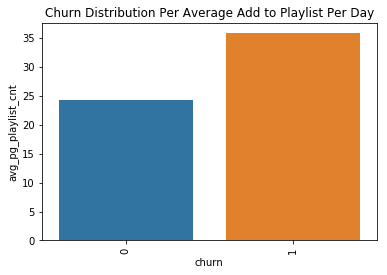

In [46]:
days_in_app_dstr = df_dataset.select(col('avg_pg_playlist_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_playlist_cnt").alias("avg_pg_playlist_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_playlist_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per Average Add to Playlist Per Day')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

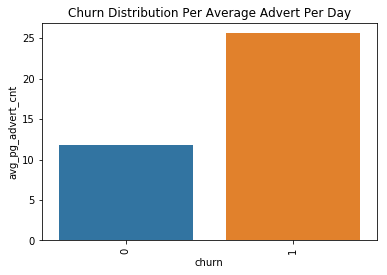

In [47]:
days_in_app_dstr = df_dataset.select(col('avg_pg_advert_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_advert_cnt").alias("avg_pg_advert_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_advert_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per Average Advert Per Day')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

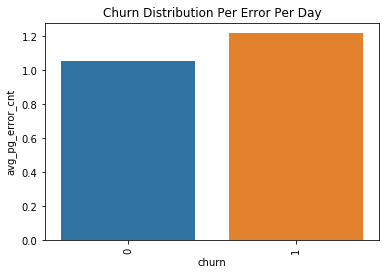

In [48]:
days_in_app_dstr = df_dataset.select(col('avg_pg_error_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_error_cnt").alias("avg_pg_error_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_error_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per Error Per Day')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

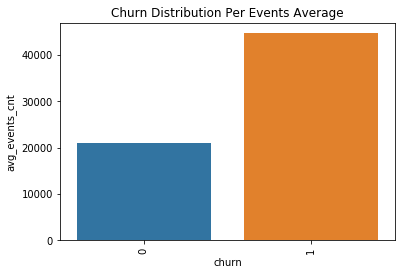

In [49]:
days_in_app_dstr = df_dataset.select(col('events_cnt'),col('churn')).groupby('churn').agg(F.mean("events_cnt").alias("avg_events_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_events_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per Events Average')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

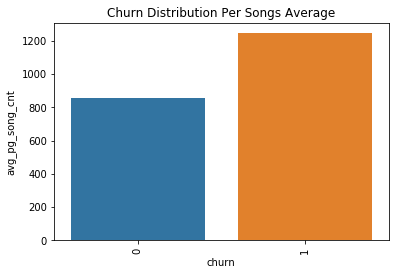

In [50]:
days_in_app_dstr = df_dataset.select(col('avg_pg_song_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_song_cnt").alias("avg_pg_song_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_song_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per Songs Average')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

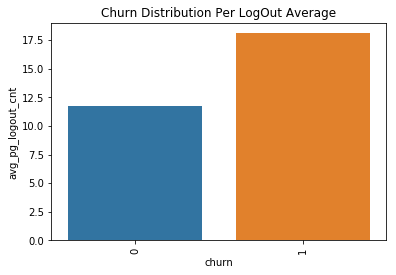

In [51]:
days_in_app_dstr = df_dataset.select(col('avg_pg_logout_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_logout_cnt").alias("avg_pg_logout_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_logout_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per LogOut Average')
plt.xticks(rotation = 90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

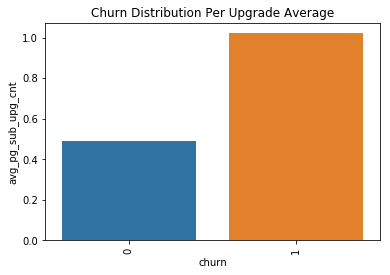

In [52]:
days_in_app_dstr = df_dataset.select(col('avg_pg_sub_upg_cnt'),col('churn')).groupby('churn').agg(F.mean("avg_pg_sub_upg_cnt").alias("avg_pg_sub_upg_cnt")).toPandas()
#is_male_flag_dstr.show()
sns.barplot('churn', 'avg_pg_sub_upg_cnt', data=days_in_app_dstr)
plt.title('Churn Distribution Per Upgrade Average')
plt.xticks(rotation = 90)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [73]:
df_dataset = spark.sql("""
SELECT   DATA.userId,
         case when gender='M' then 1 else 0 end as is_male_flag,
         max(churn) as churn,
         count(distinct ts_day) as days_in_app,
         count(distinct song)/sum(case when song is not null then 1 else 0 end) as avg_songs,
         count(distinct artist)/sum(case when song is not null then 1 else 0 end) as avg_artists,
         round(sum(length/60)/sum(case when song is not null then 1 else 0 end),2) as avg_song_length,
         count(1) as events_cnt, 
         count(1)/count(distinct ts_day) as avg_sessions_per_day,
         sum(case when DATA.page='NextSong' then 1 else 0 end)/count(distinct ts_day) as avg_pg_song_cnt,
         sum(case when DATA.page='Roll Advert' then 1 else 0 end)/count(distinct ts_day) as avg_pg_advert_cnt,
         sum(case when DATA.page='Logout' then 1 else 0 end)/count(distinct ts_day) as avg_pg_logout_cnt,
         sum(case when DATA.page='Thumbs Down' then 1 else 0 end)/count(distinct ts_day) as avg_pg_down_cnt,
         sum(case when DATA.page='Thumbs Up' then 1 else 0 end)/count(distinct ts_day) as avg_pg_up_cnt,
         sum(case when DATA.page='Add Friend' then 1 else 0 end)/count(distinct ts_day) as avg_pg_friend_cnt,
         sum(case when DATA.page='Add to Playlist' then 1 else 0 end)/count(distinct ts_day) as avg_pg_playlist_cnt,
         sum(case when DATA.page='Help' then 1 else 0 end)/count(distinct ts_day) as avg_pg_help_cnt,
         sum(case when DATA.page='Home' then 1 else 0 end)/count(distinct ts_day) as avg_pg_home_cnt,
         sum(case when DATA.page='Save Settings' then 1 else 0 end)/count(distinct ts_day) as avg_pg_save_settings_cnt,
         sum(case when DATA.page='About' then 1 else 0 end)/count(distinct ts_day) as avg_pg_about_cnt,
         sum(case when DATA.page='Settings' then 1 else 0 end)/count(distinct ts_day) as avg_pg_settings_cnt,
         sum(case when DATA.page='Login' then 1 else 0 end)/count(distinct ts_day) as avg_pg_login_cnt,
         sum(case when DATA.page='Submit Registration' then 1 else 0 end)/count(distinct ts_day) as avg_pg_sub_reg_cnt,
         sum(case when DATA.page='Register' then 1 else 0 end)/count(distinct ts_day) as avg_pg_reg_cnt,
         sum(case when DATA.page='Upgrade' then 1 else 0 end)/count(distinct ts_day) as avg_pg_upg_cnt,
         sum(case when DATA.page='Submit Upgrade' then 1 else 0 end)/count(distinct ts_day) as avg_pg_sub_upg_cnt,
         sum(case when DATA.page='Error' then 1 else 0 end)/count(distinct ts_day) as avg_pg_error_cnt
         FROM DATA
         LEFT JOIN 
         (
             SELECT distinct DATE_TRUNC('day', to_timestamp(ts/1000)) as ts_day, userId FROM DATA 
         ) day_ts
         ON day_ts.userId=DATA.userId
         GROUP BY DATA.userId,gender
""")

In [74]:
#for column in ['days_in_app','events_cnt','avg_sessions_per_day','avg_pg_song_cnt','avg_pg_advert_cnt',
#               'avg_pg_friend_cnt','avg_pg_playlist_cnt','avg_songs','avg_artists','avg_song_length',
#               'avg_pg_logout_cnt','avg_pg_sub_upg_cnt','avg_pg_upg_cnt','avg_pg_down_cnt','avg_pg_up_cnt',
#               'avg_pg_error_cnt'
#              ]:
for column in [ 'days_in_app',
                'events_cnt', 
                'avg_sessions_per_day',
                'avg_pg_song_cnt',
                'avg_pg_advert_cnt',
                'avg_pg_down_cnt',
                'avg_pg_up_cnt',
                'avg_pg_friend_cnt',
                'avg_pg_playlist_cnt',
                'avg_pg_upg_cnt',
                'avg_pg_sub_upg_cnt',
                'avg_pg_error_cnt',
                'avg_pg_logout_cnt'
                ]:
    # VectorAssembler Transformation - Converting column to vector type
    vector_assempler = VectorAssembler(inputCols=[column],outputCol=column+"_vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=column+"_vect", outputCol=column+"_scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[vector_assempler, scaler])

    # Fitting pipeline on dataframe
    df_dataset = pipeline.fit(df_dataset).transform(df_dataset).drop(column+"_vect")

In [75]:
#features_vector_assempler = VectorAssembler(inputCols=['days_in_app_scaled','events_cnt_scaled',
#                'avg_sessions_per_day_scaled','avg_pg_song_cnt_scaled','avg_pg_advert_cnt_scaled',
#               'avg_pg_friend_cnt_scaled','avg_pg_playlist_cnt_scaled','avg_songs_scaled','avg_artists_scaled',
#                'avg_song_length_scaled','avg_pg_logout_cnt_scaled','avg_pg_sub_upg_cnt_scaled',
#                'avg_pg_upg_cnt_scaled','avg_pg_down_cnt_scaled','avg_pg_up_cnt_scaled',
#               'avg_pg_error_cnt_scaled'
#                ],outputCol="features")
features_vector_assempler = VectorAssembler(inputCols=['is_male_flag',
                                'days_in_app_scaled',
                                'events_cnt_scaled', 
                                'avg_sessions_per_day_scaled',
                                'avg_pg_song_cnt_scaled',
                                'avg_pg_advert_cnt_scaled',
                                'avg_pg_down_cnt_scaled',
                                'avg_pg_up_cnt_scaled',
                                'avg_pg_friend_cnt_scaled',
                                'avg_pg_playlist_cnt_scaled',
                                'avg_pg_upg_cnt',
                                'avg_pg_sub_upg_cnt',
                                'avg_pg_error_cnt',
                                'avg_pg_logout_cnt'],outputCol="features")
df_dataset_model = features_vector_assempler.transform(df_dataset)

In [76]:
df_dataset_model = df_dataset_model.select(col("churn").alias("label"),col("features"))

In [77]:
#Test 1
train, test = df_dataset_model.randomSplit([0.8, 0.2], seed=7)
#sub_test, validation = test.randomSplit([0.5, 0.5], seed = 7)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 187
Test Dataset Count: 38


In [78]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = "label", maxIter = 10, maxDepth = 10, seed = 7)
gbt_fitted_model = gbt.fit(train)
predictions = gbt_fitted_model.transform(test)
f1 = MulticlassClassificationEvaluator(metricName = 'f1')
acc = MulticlassClassificationEvaluator(metricName = 'accuracy')
prec = MulticlassClassificationEvaluator(metricName = 'weightedPrecision')
rec = MulticlassClassificationEvaluator(metricName = 'weightedRecall')
gbt_f1_score = f1.evaluate(predictions)
gbt_acc_score = acc.evaluate(predictions)
gbt_prec_score = prec.evaluate(predictions)
gbt_rec_score = rec.evaluate(predictions)
print('GBT Accuracy: {}, GBT Precision: {}, GBT Recall: {}, GBT F1-Score: {}'.format(round(gbt_acc_score*100,2),round(gbt_prec_score*100,2),round(gbt_rec_score*100,2),round(gbt_f1_score*100,2)))

GBT Accuracy: 55.26, GBT Precision: 55.53, GBT Recall: 55.26, GBT F1-Score: 55.36


In [79]:
rf = RandomForestClassifier()
rf_fitted_model = rf.fit(train)
predictions = rf_fitted_model.transform(test)
f1 = MulticlassClassificationEvaluator(metricName = 'f1')
acc = MulticlassClassificationEvaluator(metricName = 'accuracy')
prec = MulticlassClassificationEvaluator(metricName = 'weightedPrecision')
rec = MulticlassClassificationEvaluator(metricName = 'weightedRecall')
rf_f1_score = f1.evaluate(predictions)
rf_acc_score = acc.evaluate(predictions)
rf_prec_score = prec.evaluate(predictions)
rf_rec_score = rec.evaluate(predictions)
print('Random Forest Accuracy: {}, Random Forest Precision: {}, Random Forest Recall: {}, Random Forest F1-Score: {}'.format(round(rf_acc_score*100,2),round(rf_prec_score*100,2),round(rf_rec_score*100,2),round(rf_f1_score*100,2)))

Random Forest Accuracy: 68.42, Random Forest Precision: 71.0, Random Forest Recall: 68.42, Random Forest F1-Score: 66.09


In [80]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.01)
lr_fitted_model = lr.fit(train)
predictions = lr_fitted_model.transform(test)
f1 = MulticlassClassificationEvaluator(metricName = 'f1')
acc = MulticlassClassificationEvaluator(metricName = 'accuracy')
prec = MulticlassClassificationEvaluator(metricName = 'weightedPrecision')
rec = MulticlassClassificationEvaluator(metricName = 'weightedRecall')
lr_f1_score = f1.evaluate(predictions)
lr_acc_score = acc.evaluate(predictions)
lr_prec_score = prec.evaluate(predictions)
lr_rec_score = rec.evaluate(predictions)
print('Logistic Regression Accuracy: {}, Logistic Regression Precision: {}, Logistic Regression Recall: {}, Logistic Regression F1-Score: {}'.format(round(lr_acc_score*100,2),round(lr_prec_score*100,2),round(lr_rec_score*100,2),round(lr_f1_score*100,2)))

Logistic Regression Accuracy: 63.16, Logistic Regression Precision: 63.26, Logistic Regression Recall: 63.16, Logistic Regression F1-Score: 61.51


In [81]:
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)
svm_fitted_model = svm.fit(train)
predictions = svm_fitted_model.transform(test)
f1 = MulticlassClassificationEvaluator(metricName = 'f1')
acc = MulticlassClassificationEvaluator(metricName = 'accuracy')
prec = MulticlassClassificationEvaluator(metricName = 'weightedPrecision')
rec = MulticlassClassificationEvaluator(metricName = 'weightedRecall')
svm_f1_score = f1.evaluate(predictions)
svm_acc_score = acc.evaluate(predictions)
svm_prec_score = prec.evaluate(predictions)
svm_rec_score = rec.evaluate(predictions)
print('SVM Accuracy: {}, SVM Precision: {}, SVM Recall: {}, SVM F1-Score: {}'.format(round(svm_acc_score*100,2),round(svm_prec_score*100,2),round(svm_rec_score*100,2),round(svm_f1_score*100,2)))

SVM Accuracy: 68.42, SVM Precision: 74.0, SVM Recall: 68.42, SVM F1-Score: 64.88


From the above executions and evaluations we will choosse as better performant algorythm the GBT one. 
This is the algorythm that we will use for the calculation of the churn score with these KPIs.

Of course, the next step is to evaluate and validate the results running the code on the full dataset.
If we are happy with the results we can deploy the churn calculation algorythm in production

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.